This notebook utilizes the ResNet50 model, which is fine-tuned (transfer learning) to improve classification accuracy. Prediction accuracy and complexity metrics are also explored as a function of model pruning.

In [0]:
# "standard"
import numpy as np
import pandas as pd

# machine learning and statistics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras import applications, models, layers, optimizers

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import cv2, magic, datetime, sys, os, wget, pickle
from IPython.display import clear_output

# src
import sys
sys.path.append('/Workspace/Users/bjedelma@gmail.com/Alzheimers-MRI-Classification/src')
from visualize import visualize_training

clear_output(wait=False)

Mount AWS S3 bucket containing processed data

In [0]:
ACCESS_KEY = dbutils.secrets.get(scope="brad-aws", key="access_key")
SECRET_KEY= dbutils.secrets.get(scope="brad-aws", key="secret_key")

# specify bucket and mount point
AWS_S3_BUCKET = "databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/raw/"
MOUNT_NAME = f"/mnt/{AWS_S3_BUCKET.split('/')[-2]}"
SOURCE_URL = f"s3a://{AWS_S3_BUCKET}"
EXTRA_CONFIGS = { "fs.s3a.access.key": ACCESS_KEY, "fs.s3a.secret.key": SECRET_KEY}

# mount bucket
if any(mount.mountPoint == MOUNT_NAME for mount in dbutils.fs.mounts()):
    print(f"{MOUNT_NAME} is already mounted.")
else:
    dbutils.fs.mount(SOURCE_URL, MOUNT_NAME, extra_configs = EXTRA_CONFIGS)
    print(f"{MOUNT_NAME} is now mounted.")

In [0]:
# Load data file and unpack contents
s3_file_path = 'AD_MRI_classification/preprocessed/data_pre.pkl'
file_path = f"/dbfs/mnt/{s3_file_path}"

with open(file_path, 'rb') as f:
    train_data, train_lab, test_data, test_lab = pickle.load(f)

# Convert labels to categorical
train_lab_cat = to_categorical(train_lab.astype('int8'), num_classes=4)
test_lab_cat = to_categorical(test_lab.astype('int8'), num_classes=4)

Load and adapt ResNet50

In [0]:
# load ResNet50
res_model = applications.ResNet50(include_top=False, weights=None, input_shape=(train_data.shape[1], train_data.shape[2], 3))

# Freeze all layers except the last block
for layer in res_model.layers[:-10]:
    layer.trainable = False

# Print layers to verify
for i, layer in enumerate(res_model.layers):
    print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}")

# Add a Conv2D layer to convert grayscale images to 3 channels
input_layer = layers.Input(shape=(128, 128, 1))
x = layers.Conv2D(3, (3, 3), padding='same')(input_layer)
x = res_model(x)
x = layers.Flatten()(x)
x = layers.Dense(len(np.unique(train_lab)), activation='softmax')(x)  # Add Dense layer with number of unique classes

2025-01-09 20:33:39.718547: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Layer 0: input_layer, Trainable: False
Layer 1: conv1_pad, Trainable: False
Layer 2: conv1_conv, Trainable: False
Layer 3: conv1_bn, Trainable: False
Layer 4: conv1_relu, Trainable: False
Layer 5: pool1_pad, Trainable: False
Layer 6: pool1_pool, Trainable: False
Layer 7: conv2_block1_1_conv, Trainable: False
Layer 8: conv2_block1_1_bn, Trainable: False
Layer 9: conv2_block1_1_relu, Trainable: False
Layer 10: conv2_block1_2_conv, Trainable: False
Layer 11: conv2_block1_2_bn, Trainable: False
Layer 12: conv2_block1_2_relu, Trainable: False
Layer 13: conv2_block1_0_conv, Trainable: False
Layer 14: conv2_block1_3_conv, Trainable: False
Layer 15: conv2_block1_0_bn, Trainable: False
Layer 16: conv2_block1_3_bn, Trainable: False
Layer 17: conv2_block1_add, Trainable: False
Layer 18: conv2_block1_out, Trainable: False
Layer 19: conv2_block2_1_conv, Trainable: False
Layer 20: conv2_block2_1_bn, Trainable: False
Layer 21: conv2_block2_1_relu, Trainable: False
Layer 22: conv2_block2_2_conv, Train

In [0]:
# Combine new input layer to ResNet50
model = models.Model(inputs=input_layer, outputs=x)
std_learning_rate = 1e-4
model.compile(optimizer = keras.optimizers.Adam(learning_rate = std_learning_rate),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │       131,076 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,718,818 (90.48 MB)

 Trainable params: 4,596,770 (17.54 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

In [0]:
# Train the model
history = model.fit(
    train_data, train_lab_cat, epochs=20, 
    validation_data=(test_data, test_lab_cat)
)

2025-01-09 12:46:56.722540: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 676003840 exceeds 10% of free system memory.


Epoch 1/20


2025-01-09 12:47:49.138630: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2025-01-09 12:47:49.405662: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 35684352 exceeds 10% of free system memory.
2025-01-09 12:47:49.516360: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2025-01-09 12:47:49.815797: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.


135/323 ━━━━━━━━━━━━━━━━━━━━[

*** WARNING: max output size exceeded, skipping output. ***

323/323 ━━━━━━━━━━━━━━━━━━━━ 1283s 4s/step - accuracy: 0.9519 - loss: 0.1369 - val_accuracy: 0.4430 - val_loss: 6.3507


In [0]:
# Save model and results
cwd = os.getcwd()
results_dir = os.path.join(os.path.dirname(cwd), 'results')

model_file = os.path.join(results_dir, 'model_resnet50.h5')
results_file = os.path.join(results_dir, 'history_resnet50.pkl')

# Save model
model.save(model_file)
with open(results_file, 'wb') as f:
    pickle.dump(history, f)
clear_output(wait=False)

print(f"Model saved as: {model_file}")
print(f"Training results saved as: {results_file}")

Model saved as: /Workspace/Users/bjedelma@gmail.com/Alzheimers-MRI-Classification/results/model.h5
Training results saved as: /Workspace/Users/bjedelma@gmail.com/Alzheimers-MRI-Classification/results/history.pkl


View results

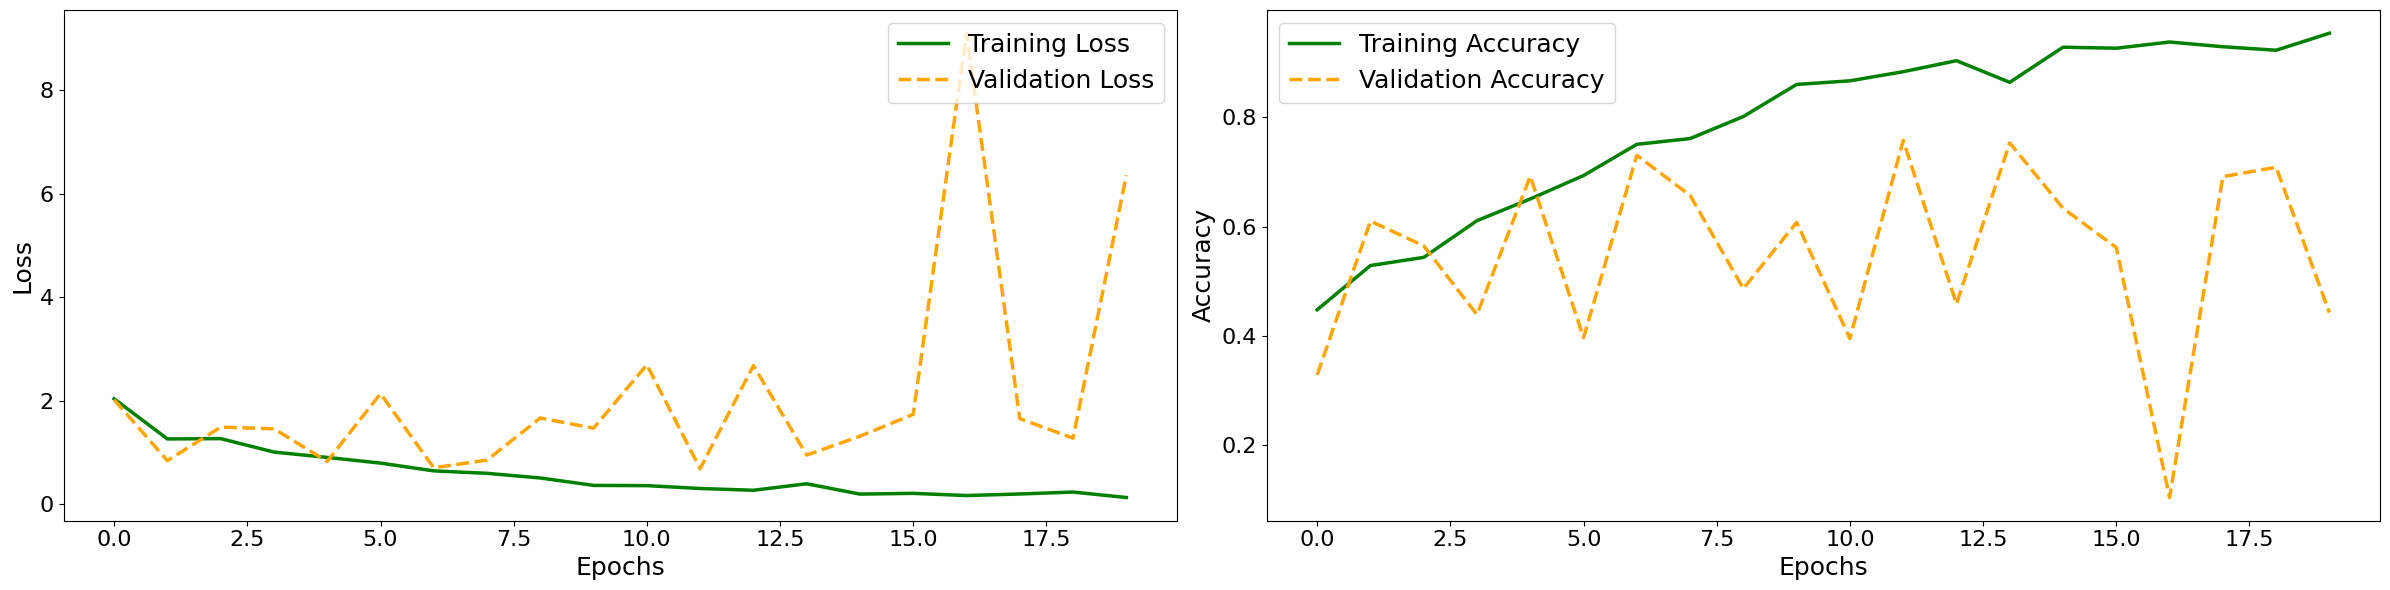

In [0]:
visualize_training(history)

Fine tune the ResNet50

Since this is a relatively small dataset, let's unfreeze only the final few layers of the network (rather than all) for retraining

In [0]:
# How many layers are in the base model
print("Number of layers in ResNet50: ", len(res_model.layers))

# For now, unfreeze last whole convolutional block for fine tuning
fine_tune_at = 143
for layer in res_model.layers[fine_tune_at:]:
  layer.trainable = True

# Print layers to verify
for i, layer in enumerate(res_model.layers):
    print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}")

# Add a Conv2D layer to convert grayscale images to 3 channels
input_layer = layers.Input(shape=(128, 128, 1))
x = layers.Conv2D(3, (3, 3), padding='same')(input_layer)
x = res_model(x)
x = layers.Flatten()(x)
x = layers.Dense(4, activation='softmax')(x)  # Add Dense layer with number of classes

model = models.Model(inputs=input_layer, outputs=x)
std_learning_rate = 1e-5 # use lower learning rate with more trainable layers
model.compile(optimizer = keras.optimizers.Adam(learning_rate = std_learning_rate),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']
)
model.summary()


Number of layers in ResNet50:  175
Layer 0: input_layer, Trainable: False
Layer 1: conv1_pad, Trainable: False
Layer 2: conv1_conv, Trainable: False
Layer 3: conv1_bn, Trainable: False
Layer 4: conv1_relu, Trainable: False
Layer 5: pool1_pad, Trainable: False
Layer 6: pool1_pool, Trainable: False
Layer 7: conv2_block1_1_conv, Trainable: False
Layer 8: conv2_block1_1_bn, Trainable: False
Layer 9: conv2_block1_1_relu, Trainable: False
Layer 10: conv2_block1_2_conv, Trainable: False
Layer 11: conv2_block1_2_bn, Trainable: False
Layer 12: conv2_block1_2_relu, Trainable: False
Layer 13: conv2_block1_0_conv, Trainable: False
Layer 14: conv2_block1_3_conv, Trainable: False
Layer 15: conv2_block1_0_bn, Trainable: False
Layer 16: conv2_block1_3_bn, Trainable: False
Layer 17: conv2_block1_add, Trainable: False
Layer 18: conv2_block1_out, Trainable: False
Layer 19: conv2_block2_1_conv, Trainable: False
Layer 20: conv2_block2_1_bn, Trainable: False
Layer 21: conv2_block2_1_relu, Trainable: False
L

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │       131,076 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,718,818 (90.48 MB)

 Trainable params: 15,107,106 (57.63 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

In [0]:
# Train the model
history_fine_tune = model.fit(
    train_data, train_lab_cat, epochs=20, 
    validation_data=(test_data, test_lab_cat)
)

2025-01-09 20:33:50.093855: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 676003840 exceeds 10% of free system memory.


Epoch 1/20


2025-01-09 20:34:24.774553: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2025-01-09 20:34:24.849451: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 35684352 exceeds 10% of free system memory.
2025-01-09 20:34:24.875466: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2025-01-09 20:34:24.945979: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.


135/323 ━━━━━━━━━━━━━━━━━━━━ 12:48 4s/step

*** WARNING: max output size exceeded, skipping output. ***

323/323 ━━━━━━━━━━━━━━━━━━━━ 1392s 4s/step - accuracy: 0.4781 - loss: 1.3191 - val_accuracy: 0.6719 - val_loss: 0.8069
Epoch 2/20
 12/323 ━━━━━━━━━━━━━━━━━━━━ 21:26 4s/step - accuracy: 0.7942 - loss: 0.5851

In [0]:
# Save model and results
cwd = os.getcwd()
results_dir = os.path.join(os.path.dirname(cwd), 'results')

model_file = os.path.join(results_dir, 'model_resnet50_fine_tune.h5')
results_file = os.path.join(results_dir, 'history_resnet50_fine_tune.pkl')

model.save(model_file)
with open(results_file, 'wb') as f:
    pickle.dump(history_fine_tune, f)
clear_output(wait=False)

print(f"Model saved as: {model_file}")
print(f"Training results saved as: {results_file}")

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:717)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

In [0]:
visualize_training(history_fine_tune)

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:434)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:458)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:706)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:508)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:613)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:636)
	at com.databricks.logging.AttributionContextTracing.$anonfun$withAttributionContext$1(AttributionContextTracing.scala:49)
	at com.databricks.logging.AttributionContext$.$anonfun$withValue$1(AttributionContext.scala:295)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(Attr

Prune model

In [0]:
# import tensorflow_model_optimization as tfmot
# import numpy as np

# # Define pruning parameters
# pruning_params = {
#     'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
#         initial_sparsity=0.0, final_sparsity=0.5, begin_step=0, end_step=np.ceil(len(train_data) / 32).astype(np.int32) * 10
#     )
# }

# # Create a list to store results
# pruning_results = []

# # Loop over different pruning amounts
# for sparsity in np.linspace(0.1, 0.9, 9):
#     # Update pruning parameters
#     pruning_params['pruning_schedule'] = tfmot.sparsity.keras.PolynomialDecay(
#         initial_sparsity=0.0, final_sparsity=sparsity, begin_step=0, end_step=np.ceil(len(train_data) / 32).astype(np.int32) * 10
#     )
    
#     # Apply pruning to the model
#     model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)
    
#     # Compile the pruned model
#     model_for_pruning.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
#     # Train the pruned model
#     model_for_pruning.fit(train_data, train_labels_cat, epochs=10, validation_data=(test_data, test_labels_cat))
    
#     # Evaluate the pruned model
#     test_loss, test_accuracy = model_for_pruning.evaluate(test_data, test_labels_cat)
    
#     # Save the pruned model
#     model_for_pruning.save(f'pruned_model_sparsity_{sparsity:.1f}.h5')
    
#     # Record the model size, number of parameters, and test set classification
#     model_size = os.path.getsize(f'pruned_model_sparsity_{sparsity:.1f}.h5')
#     num_params = model_for_pruning.count_params()
    
#     pruning_results.append({
#         'sparsity': sparsity,
#         'model_size': model_size,
#         'num_params': num_params,
#         'test_accuracy': test_accuracy
#     })

# # Convert results to a DataFrame for later plotting
# pruning_results_df = pd.DataFrame(pruning_results)
# display(pruning_results_df)